Mounted at /content/drive
Best RBF Model Parameters: {'alpha': 0.001, 'gamma': 2.2958671050263857}
Train MAE: 5.219303856033232e-05, Test MAE: 6.067506635054641e-05
Train MSE: 1.0423554787222093e-08, Test MSE: 1.5989277721744536e-08
Train RRMSE: 0.0193, Test RRMSE: 0.0415
Train R²: 0.9557, Test R²: 0.9011
Train AAPRE: 546.6953%, Test AAPRE: 434.7089%
Train RAE: 0.2225, Test RAE: 0.2905



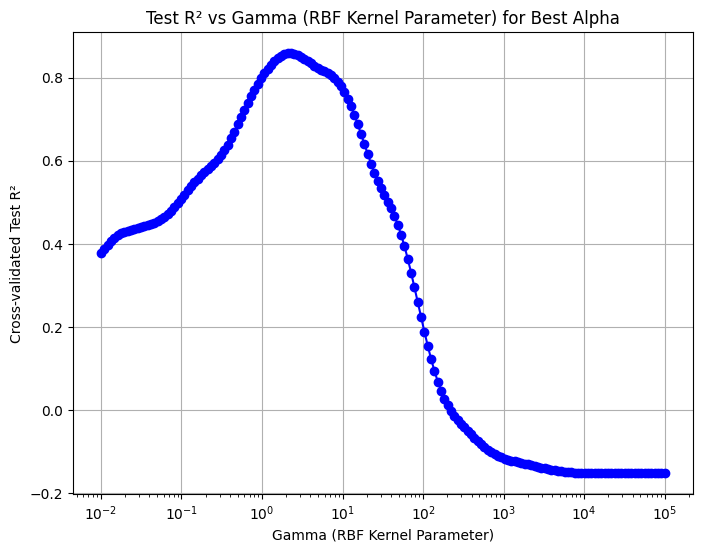

In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

# Load data
df = pd.read_csv('/content/drive/My Drive/drugdata.csv')
df=df.iloc[:, :6].dropna()
X = df.iloc[:, :5]
y = df.iloc[:, 5]
d = 1000000

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Function to calculate evaluation metrics including RAE
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    aapre = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # RAE calculation
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

    return mae, mse, rrmse, r2, aapre, rae

# Define the RBF model (Kernel Ridge Regression with RBF kernel)
# Parameters to tune: alpha (regularization), gamma (RBF kernel parameter)
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': np.logspace(-2, 5, 170)
}
kr_model = KernelRidge(kernel='rbf')

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(kr_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled, validation_fraction=0.15)

# Best model after hyperparameter tuning
best_kr_model = grid_search.best_estimator_

# Make predictions
y_train_pred_scaled = best_kr_model.predict(X_train_scaled)
y_test_pred_scaled = best_kr_model.predict(X_test_scaled)

# Denormalize the predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics for training and testing sets
train_mae, train_mse, train_rrmse, train_r2, train_aapre, train_rae = calculate_metrics(y_train / d, y_train_pred / d)
test_mae, test_mse, test_rrmse, test_r2, test_aapre, test_rae = calculate_metrics(y_test / d, y_test_pred / d)

# Print results
print(f"Best RBF Model Parameters: {grid_search.best_params_}")
print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
print(f"Train RRMSE: {train_rrmse:.4f}, Test RRMSE: {test_rrmse:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
print(f"Train RAE: {train_rae:.4f}, Test RAE: {test_rae:.4f}\n")

# Extract the mean test R² scores and corresponding parameters
mean_test_r2 = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

# Filter out R² scores corresponding to the best alpha
best_alpha = grid_search.best_params_['alpha']
filtered_r2 = [mean_test_r2[i] for i in range(len(params)) if params[i]['alpha'] == best_alpha]
filtered_gamma = [params[i]['gamma'] for i in range(len(params)) if params[i]['alpha'] == best_alpha]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(filtered_gamma, filtered_r2, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Gamma (RBF Kernel Parameter)')
plt.ylabel('Cross-validated Test R²')
plt.title('Test R² vs Gamma (RBF Kernel Parameter) for Best Alpha')
plt.grid(True)
plt.show()


In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# Load data
df = pd.read_csv('/content/drive/My Drive/drugdata.csv')
X = df.iloc[:, :5]
y = df.iloc[:, 5]
d = 1000000

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into 85% for training and 15% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Scale the data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    aapre = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # RAE calculation
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

    return mae, mse, rrmse, r2, aapre, rae

# Define the RBF model (Kernel Ridge Regression with RBF kernel) with fixed parameters
kr_model = KernelRidge(kernel='rbf', alpha=0.001, gamma=10)

# Fit the model on the training set
kr_model.fit(X_train_scaled, y_train_scaled)

# Make predictions on training, validation, and testing sets
y_train_pred_scaled = kr_model.predict(X_train_scaled)
y_val_pred_scaled = kr_model.predict(X_val_scaled)
y_test_pred_scaled = kr_model.predict(X_test_scaled)

# Denormalize the predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics for training, validation, and testing sets
train_mae, train_mse, train_rrmse, train_r2, train_aapre, train_rae = calculate_metrics(y_train / d, y_train_pred / d)
val_mae, val_mse, val_rrmse, val_r2, val_aapre, val_rae = calculate_metrics(y_val / d, y_val_pred / d)
test_mae, test_mse, test_rrmse, test_r2, test_aapre, test_rae = calculate_metrics(y_test / d, y_test_pred / d)

# Print results
print(f"Kernel Ridge Regression with alpha=0.001 and gamma=10")
print(f"Train MAE: {train_mae}, Validation MAE: {val_mae}, Test MAE: {test_mae}")
print(f"Train MSE: {train_mse}, Validation MSE: {val_mse}, Test MSE: {test_mse}")
print(f"Train RRMSE: {train_rrmse:.4f}, Validation RRMSE: {val_rrmse:.4f}, Test RRMSE: {test_rrmse:.4f}")
print(f"Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}, Test R²: {test_r2:.4f}")
print(f"Train AAPRE: {train_aapre:.4f}%, Validation AAPRE: {val_aapre:.4f}%, Test AAPRE: {test_aapre:.4f}%")
print(f"Train RAE: {train_rae:.4f}, Validation RAE: {val_rae:.4f}, Test RAE: {test_rae:.4f}\n")

# Optional: Plotting metrics for comparison between train, validation, and test sets
labels = ['Train', 'Validation', 'Test']
mae_values = [train_mae, val_mae, test_mae]
mse_values = [train_mse, val_mse, test_mse]
rmse_values = [np.sqrt(train_mse), np.sqrt(val_mse), np.sqrt(test_mse)]
r2_values = [train_r2, val_r2, test_r2]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MAE Plot
axes[0, 0].bar(labels, mae_values, color=['blue', 'orange', 'green'])
axes[0, 0].set_title('Mean Absolute Error (MAE)')

# MSE Plot
axes[0, 1].bar(labels, mse_values, color=['blue', 'orange', 'green'])
axes[0, 1].set_title('Mean Squared Error (MSE)')

# RMSE Plot
axes[1, 0].bar(labels, rmse_values, color=['blue', 'orange', 'green'])
axes[1, 0].set_title('Root Mean Squared Error (RMSE)')

# R² Plot
axes[1, 1].bar(labels, r2_values, color=['blue', 'orange', 'green'])
axes[1, 1].set_title('R²')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# Load data
df = pd.read_csv('/content/drive/My Drive/drugdata.csv')
X = df.iloc[:, :5]
y = df.iloc[:, 5]
d = 1000000

# Set the number of splits (folds) for cross-validation
n_splits = 4
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Function to calculate evaluation metrics including RAE
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    aapre = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # RAE calculation
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

    return mae, mse, rrmse, r2, aapre, rae

# List to store all metrics
all_metrics = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    # Split data according to the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    scaler_X = MinMaxScaler()
    X_train_scaled_fold = scaler_X.fit_transform(X_train_fold)
    X_test_scaled_fold = scaler_X.transform(X_test_fold)

    scaler_y = MinMaxScaler()
    y_train_scaled_fold = scaler_y.fit_transform(y_train_fold.values.reshape(-1, 1)).flatten()
    y_test_scaled_fold = scaler_y.transform(y_test_fold.values.reshape(-1, 1)).flatten()

    # Define the Kernel Ridge model (Kernel Ridge Regression with RBF kernel) with fixed parameters
    kr_model = KernelRidge(kernel='rbf', alpha=0.001, gamma=10)

    # Fit the Kernel Ridge model
    kr_model.fit(X_train_scaled_fold, y_train_scaled_fold)

    # Make predictions
    y_train_pred_scaled_fold = kr_model.predict(X_train_scaled_fold)
    y_test_pred_scaled_fold = kr_model.predict(X_test_scaled_fold)

    # Denormalize the predictions
    y_train_pred_fold = scaler_y.inverse_transform(y_train_pred_scaled_fold.reshape(-1, 1)).flatten()
    y_test_pred_fold = scaler_y.inverse_transform(y_test_pred_scaled_fold.reshape(-1, 1)).flatten()

    # Calculate metrics for training and testing sets
    train_mae, train_mse, train_rrmse, train_r2, train_aapre, train_rae = calculate_metrics(y_train_fold / d, y_train_pred_fold / d)
    test_mae, test_mse, test_rrmse, test_r2, test_aapre, test_rae = calculate_metrics(y_test_fold / d, y_test_pred_fold / d)

    # Store metrics for this fold
    all_metrics.append({
        'fold': fold,
        'train_mae': train_mae, 'train_mse': train_mse, 'train_rrmse': train_rrmse,
        'train_r2': train_r2, 'train_aapre': train_aapre, 'train_rae': train_rae,
        'test_mae': test_mae, 'test_mse': test_mse, 'test_rrmse': test_rrmse,
        'test_r2': test_r2, 'test_aapre': test_aapre, 'test_rae': test_rae
    })

# Convert the list of dictionaries to a DataFrame for easier analysis
metrics_df = pd.DataFrame(all_metrics)

# Calculate the mean of the metrics across all folds
mean_metrics = metrics_df.mean()
print("Average Metrics Across Folds:")
print(mean_metrics)

# Optionally, save the metrics to a CSV file
metrics_df.to_csv('/content/drive/My Drive/kernel_ridge_cv_results.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Average Metrics Across Folds:
fold           2.500000e+00
train_mae      7.315718e-06
train_mse      2.227188e-10
train_rrmse    3.046410e-03
train_r2       9.989774e-01
train_aapre    7.567044e+01
train_rae      3.178090e-02
test_mae       6.562679e-05
test_mse       2.317367e-08
test_rrmse     3.930172e-02
test_r2        8.619632e-01
test_aapre     6.854800e+02
test_rae       2.969223e-01
dtype: float64


In [ ]:
all_metrics

[{'fold': 1,
  'train_mae': 7.443115352969948e-06,
  'train_mse': 2.2310957886834375e-10,
  'train_rrmse': 0.002829003019819411,
  'train_r2': 0.9991366296403658,
  'train_aapre': 64.66428545234399,
  'train_rae': 0.0299178924945183,
  'test_mae': 6.262057675779748e-05,
  'test_mse': 3.493476816611221e-08,
  'test_rrmse': 0.06128788876916385,
  'test_r2': 0.6911458467402944,
  'test_aapre': 594.1872784875526,
  'test_rae': 0.3532066115573406},
 {'fold': 2,
  'train_mae': 7.727696937693521e-06,
  'train_mse': 2.394357017544716e-10,
  'train_rrmse': 0.002930682402900927,
  'train_r2': 0.9990411318743018,
  'train_aapre': 86.16675426003783,
  'train_rae': 0.03121270562141848,
  'test_mae': 6.097983167777209e-05,
  'test_mse': 1.2945895421173023e-08,
  'test_rrmse': 0.031695199912351424,
  'test_r2': 0.9067718315034042,
  'test_aapre': 1076.3045518167053,
  'test_rae': 0.3363802323765237},
 {'fold': 3,
  'train_mae': 7.229545020975279e-06,
  'train_mse': 2.1203618676407785e-10,
  'train_rr